##  Age-structured SIR model for India

We can now generalise the model in example-2 to more than two age groups. Assume that the population has been partitioned into  $i=1,\ldots, M$ age groups and that we have available the $M\times M$ contact matrix $C_{ij}$. These are a sum of contributions from contacts at home, workplace, schools and all other public spheres. Using superscripts $H$, $W$, $S$ and $O$ for each of these, we write the contact matrix as
$$
C_{ij} = C^H_{ij} + C^W_{ij} + C^S_{ij} + C^O_{ij}
$$
We read in these contact matrices from the data sets provided in the paper *Projecting social contact matrices in 152 countries using contact surveys and demographic data* by Prem et al, sum them to obtain the total contact matrix. We also read in the age distribution of India obtained from the *Population pyramid* website. The infection parameter $\beta$ is unknown, so we fit it to the case data till 25th March. The hope is that this will take into account the fact that there are, in reality, asymptomatic infectives, and that the symptomatic cases are an understimate. Also, the model is being applied to the whole of India, where the well-mixedness of the population, implicit in a non-spatial model, breaks down. This type of fitting gets more accurate, though, when it is applied to more local regions, where the well-mixedness is a better assumption. We then run the simulation, assuming all initial cases are symptomatic, and remain so. This will be an underestimate in the initial stages but once the epidemic enters the non-linear phase, there will be must less sensitivity to the initial condition. At the end of the simulation, we extract the number of susceptibles remaining in each age group, and the difference with the initial number of susceptibles is the total number that are infected. We multiply this with mortality data from China to obtain mortality estimates. 

In [26]:
%%capture
## compile PyRoss for this notebook
import os
owd = os.getcwd()
os.chdir('../../')
%run setup.py install
os.chdir(owd)

CompileError: pyross/deterministic.pyx

In [16]:
%matplotlib inline
import numpy as np
import pyross
import pandas as pd
import matplotlib.pyplot as plt

In [17]:
M=16  # number of age groups

# load age structure data
my_data = np.genfromtxt('../data/age_structures/UK.csv', delimiter=',', skip_header=1)
aM, aF = my_data[:, 1], my_data[:, 2]

# set age groups
Ni=aM+aF;   Ni=Ni[0:M];  N=np.sum(Ni)

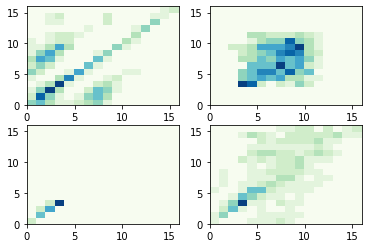

In [25]:
# contact matrices
my_data = pd.read_excel('../data/contact_matrices_152_countries/MUestimates_home_2.xlsx', sheet_name='United Kingdom of Great Britain')
CH0 = np.array(my_data)

my_data = pd.read_excel('../data/contact_matrices_152_countries/MUestimates_work_2.xlsx', sheet_name='United Kingdom of Great Britain',index_col=None)
CW0 = np.array(my_data)

my_data = pd.read_excel('../data/contact_matrices_152_countries/MUestimates_school_2.xlsx', sheet_name='United Kingdom of Great Britain',index_col=None)
CS0 = np.array(my_data)

my_data = pd.read_excel('../data/contact_matrices_152_countries/MUestimates_other_locations_2.xlsx', sheet_name='United Kingdom of Great Britain',index_col=None)
CO0 = np.array(my_data)

CH = np.zeros((16, 16))
CH[0,:]= np.array((0.478812799633172, 0.55185413960287,0.334323605154544,0.132361228266194,0.138531587861408,0.281604887066586,0.406440258772792,0.493947983343078,0.113301080935514,0.0746826413664804,0.0419640342896305,0.0179831987029717,0.00553694264516568,0.00142187285266089,0,0.000505582193632659))
for i in range(15):
    CH[i+1, :] = CH0[i, :]

    
CW = np.zeros((16, 16))
CW[0,:]= np.array((0,0,0,0,0,0,0,0,0,0,0,0,0,0.0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000820604524144799,0.0000120585150153575,0.0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000316436833811157))
for i in range(15):
    CW[i+1, :] = CW0[i, :]

    
CS = np.zeros((16, 16))
CS[0,:]= np.array((0.974577996106766,0.151369805263473,0.00874880925953218,0.0262790907947637,0.0111281607429249,0.0891043051294382,0.125477587043249,0.0883182775274553,0.0371824197201174,0.0294092695284747,0.0000000000000000000000000000000000000510911446027435,0.0000000000000000000000000000000113982464440009,0.00758428705895781,0.00151636767747242,0.0000000000000000000000000000000000000000000000000123262013953524,0.000000000000000000000000000000000000000000000000000000000000000597486362181075))
for i in range(15):
    CS[i+1, :] = CS0[i, :]

CO = np.zeros((16, 16))
CO[0,:]= np.array((0.257847576361162,0.100135168376607,0.0458036773638843,0.127084549151753,0.187303683093508,0.257979214509792,0.193228849121415,0.336594916946786,0.309223290169635,0.070538522966953,0.152218422246435,0.113554851510519,0.0615771477785246,0.040429874099682,0.0373564987094767,0.00669781557624776))
for i in range(15):
    CO[i+1, :] = CO0[i, :]

## matrix of total contacts
C=CH+CW+CS+CO



fig,aCF =  plt.subplots(2,2);
aCF[0][0].pcolor(CH, cmap=plt.cm.get_cmap('GnBu', 10));
aCF[0][1].pcolor(CW, cmap=plt.cm.get_cmap('GnBu', 10));
aCF[1][0].pcolor(CS, cmap=plt.cm.get_cmap('GnBu', 10));
aCF[1][1].pcolor(CO, cmap=plt.cm.get_cmap('GnBu', 10));

In [19]:
beta  = 0.01646692       # infection rate 
gIa   = 1./7             # recovery rate of asymptomatic infectives 
gIs   = 1./7             # recovery rate of symptomatic infectives 
alpha = 0.               # fraction of asymptomatic infectives 
fsa   = 1                # the self-isolation parameter   
    
    
# initial conditions    
Is_0 = np.zeros((M));  Is_0[6:13]=3;  Is_0[2:6]=1

Ia_0 = np.zeros((M))
R_0  = np.zeros((M))
S_0  = Ni - (Ia_0 + Is_0 + R_0)


# matrix for linearised dynamics
L0 = np.zeros((M, M))
L  = np.zeros((2*M, 2*M))

for i in range(M):
    for j in range(M):
        L0[i,j]=C[i,j]*Ni[i]/Ni[j]

L[0:M, 0:M]     =    alpha*beta/gIs*L0
L[0:M, M:2*M]   = fsa*alpha*beta/gIs*L0
L[M:2*M, 0:M]   =    ((1-alpha)*beta/gIs)*L0
L[M:2*M, M:2*M] = fsa*((1-alpha)*beta/gIs)*L0


r0 = np.max(np.linalg.eigvals(L))
print("The basic reproductive ratio for these parameters is", r0)

The basic reproductive ratio for these parameters is (1.3462694204918029+0j)


In [ ]:
# duration of simulation and data file
Tf=41;  Nf=2000;  

# the contact structure is independent of time 
def contactMatrix(t):
    return C

# intantiate model
parameters = {'alpha':alpha,'beta':beta, 'gIa':gIa,'gIs':gIs,'fsa':fsa}
model = pyross.deterministic.SIR(parameters, M, Ni)


# run model
data=model.simulate(S_0, Ia_0, Is_0, contactMatrix, Tf, Nf)

In [ ]:
t = data['t']; IC  = np.zeros((Nf))
for i in range(M):
        IC += data['X'][:,2*M+i]
        

        
fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})

plt.plot(t, IC, '-', lw=4, color='#A60628', label='forecast', alpha=0.8)
plt.xticks(np.arange(0, Tf, 10), ('4 Mar', '14 Mar', '24 Mar', '3 Apr', '13 Apr', '23 Apr'));

my_data = np.genfromtxt('../data/covid-cases/india.txt', delimiter='', skip_header=6)
day, cases = my_data[:,0], my_data[:,3] - my_data[:,1]


plt.plot(cases, 'o-', lw=4, color='#348ABD', ms=16, label='data', alpha=0.5)

plt.legend(fontsize=26, loc='upper left'); plt.grid() 
plt.autoscale(enable=True, axis='x', tight=True)
plt.ylabel('Infected individuals'); #plt.xlim(0, 40); plt.ylim(0, 9999);
#plt.savefig('/Users/rsingh/Desktop/2a.png', format='png', dpi=212)

In [ ]:
cases

In [ ]:
C=CH+CW+CS+CO
Tf=200; 

# matrix for linearised dynamics
L0 = np.zeros((M, M))
L  = np.zeros((2*M, 2*M))

for i in range(M):
    for j in range(M):
        L0[i,j]=C[i,j]*Ni[i]/Ni[j]
L[0:M, 0:M]     =    alpha*beta/gIs*L0
L[0:M, M:2*M]   = fsa*alpha*beta/gIs*L0
L[M:2*M, 0:M]   =    ((1-alpha)*beta/gIs)*L0
L[M:2*M, M:2*M] = fsa*((1-alpha)*beta/gIs)*L0

r0 = np.max(np.linalg.eigvals(L))
print("The basic reproductive ratio for these parameters is", r0)


def contactMatrix(t):
    return C


# start simulation
Nf=2000; 
data=model.simulate(S_0, Ia_0, Is_0, contactMatrix, Tf, Nf)

In [ ]:
t = data.get('t'); IC  = np.zeros((Nf));  SC  = np.zeros((Nf))
for i in range(M):
        SC += data.get('X')[:,0*M+i]
        IC += data.get('X')[:,2*M+i]

            

fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})

plt.plot(t, SC*10**(-6), '-', lw=4, color='#348ABD', label='susceptible', alpha=0.8,)
plt.fill_between(t, 0, SC*10**(-6), color="#348ABD", alpha=0.3)

plt.plot(t, IC*10**(-6), '-', lw=4, color='#A60628', label='infected', alpha=0.8)
plt.fill_between(t, 0, IC*10**(-6), color="#A60628", alpha=0.3)

my_data = np.genfromtxt('../data/covid-cases/india.txt', delimiter='', skip_header=6)
day, cases = my_data[:,0], my_data[:,3] - my_data[:,1]
plt.plot(cases*10**(-6), 'ro-', lw=4, color='dimgrey', ms=16, label='data', alpha=0.5)

plt.legend(fontsize=26); plt.grid() 
plt.autoscale(enable=True, axis='x', tight=True)
plt.ylabel('Individuals (millions)')
plt.plot(t*0+t[np.argsort(IC)[-1]], -170+.4*SC*10**(-6), lw=4, color='g', alpha=0.8)
plt.xticks(np.arange(0, 200, 30), ('4 Mar', '3 Apr', '3 May', '2 Jun', '2 Jul', '1 Aug', '31 Aug'));
#plt.savefig('/Users/rsingh/Desktop/2b.png', format='png', dpi=212)

In [ ]:
IC[np.argsort(IC)[-1]]
IC
cases

In [ ]:
# matrix for linearised dynamics
L0 = np.zeros((M, M))
L  = np.zeros((2*M, 2*M))
xind=[np.argsort(IC)[-1]]
rr = np.zeros((Tf))

for tt in range(Tf):
    Si = np.array((data['X'][tt*10,0:M])).flatten()
    for i in range(M):
        for j in range(M):
            L0[i,j]=C[i,j]*Si[i]/Ni[j]
    L[0:M, 0:M]     =    alpha*beta/gIs*L0
    L[0:M, M:2*M]   = fsa*alpha*beta/gIs*L0
    L[M:2*M, 0:M]   =    ((1-alpha)*beta/gIs)*L0
    L[M:2*M, M:2*M] = fsa*((1-alpha)*beta/gIs)*L0

    rr[tt] = np.real(np.max(np.linalg.eigvals(L)))
    
    
fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})

plt.plot(t[::10], rr, 'o', lw=4, color='#A60628', label='suscetible', alpha=0.8,)
plt.fill_between(t, 0, t*0+1, color="dimgrey", alpha=0.2); plt.ylabel('Basic reproductive ratio')
plt.ylim(np.min(rr)-.1, np.max(rr)+.1)
plt.xticks(np.arange(0, 200, 30), ('4 Mar', '3 Apr', '3 May', '2 Jun', '2 Jul', '1 Aug', '31 Aug'));
#plt.savefig('/Users/rsingh/Desktop/test.png', format='png', dpi=212) 

In [ ]:
fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})

plt.bar(np.arange(16),data.get('X')[0,0:M]*10**(-6),   label='susceptible (initial)', alpha=0.8)
plt.bar(np.arange(16),data.get('X')[-1,0:M]*10**(-6),   label='susceptible (final)', alpha=0.8)

plt.xticks(np.arange(-0.4, 16.45, 3.95), ('0', '20', '40', '60', '80'));
plt.xlim(-0.45, 15.45); plt.ylabel('Individuals (millions)'); plt.xlabel('Age')
plt.legend(fontsize=22); plt.axis('tight')
plt.autoscale(enable=True, axis='x', tight=True)
#plt.savefig('/Users/rsingh/Desktop/3a.png', format='png', dpi=212)

In [ ]:
MM = np.array((0,0,.2,.2,.2,.2,.2,.2,.4,.4,1.3,1.3,3.6,3.6,8,8))  
## Fatality Rate by AGE per 100 cases

In [ ]:
fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})

m1 = .01*MM*(data.get('X')[0,0:M]-data['X'][-1,0:M])
plt.bar(np.arange(16),m1*10**(-6),   label='susceptible (final)', alpha=0.8)

plt.axis('tight'); plt.xticks(np.arange(-0.4, 16.45, 3.95), ('0', '20', '40', '60', '80'));
plt.xlim(-0.45, 15.45); plt.ylabel('Mortality (millions)'); plt.xlabel('Age')

plt.autoscale(enable=True, axis='x', tight=True)
#plt.savefig('/Users/rsingh/Desktop/3b.png', format='png', dpi=212)

In [ ]:
m1 = .01*MM*(data['X'][0,0:M]-data['X'][-1,0:M])
np.sum(m1)

In [ ]:
SC[0]-SC[-1]

In [ ]:
900*10^7

In [6]:
my_data = pd.read_excel('../data/contact_matrices_152_countries/MUestimates_home_2.xlsx', sheet_name='United Kingdom of Great Britain', skipcolumns=None)
CH = np.array(my_data)

print(np.shape(CH))

CH

0.478812799633172	0.55185413960287	0.334323605154544	0.132361228266194	0.138531587861408	0.281604887066586	0.406440258772792	0.493947983343078	0.113301080935514	0.0746826413664804	0.0419640342896305	0.0179831987029717	0.00553694264516568	0.00142187285266089	0	0.000505582193632659
0.263264242853915	0.918274813032867	0.524179768293367	0.116285330911719	0.0250556852009633	0.169858750437313	0.448042261638523	0.577627602440566	0.324781960233104	0.0722768451255227	0.0265332305560519	0.00585664492198895	0	0.00242040179581532	0.000285809310147521	0
0.168812074738478	0.535714613999342	1.08021932311361	0.388591513400032	0.0393145217431833	0.0110571286138906	0.216808970288056	0.591908716507192	0.485585641686204	0.133959469164567	0.0443333866873951	0.0175951639391087	0.0046767788815553	0.00751152993883859	0.00119829213029357	0.000239287711188863
0.0939012806569673	0.153999087758101	0.417215825714956	0.979076096622083	0.128063143865367	0.0334981190486578	0.0610027033611096	0.2536066383098	0.421886057243965	0.206528142358618	0.0749213693733798	0.0480225160760963	0.00719471109299978	0.0245565827044619	0.00239744368252006	0
0.167946316863972	0.0808360896937447	0.0728418698360438	0.356303405484223	0.804795339868319	0.205901994671027	0.0748746418161866	0.0413841822037211	0.164106139062714	0.283182758217154	0.0809986833877914	0.0853108113622529	0.0164317496426438	0.00756076605174901	0.00105155414924106	0.00157920159555511
0.489661848427621	0.296565218012358	0.0398977025859805	0.0661533091934946	0.125000620265036	0.659542030285412	0.210168617011651	0.0253383507478549	0.00744119119122348	0.046801553264022	0.167113551977528	0.110846330243133	0.0336293190500164	0.00083936704448346	0	0.00000294523466757276
0.319984866294869	0.472630659315042	0.269616873199268	0.0755885939826566	0.0466457339703206	0.0884928987898915	0.642245624672762	0.148784529327479	0.0325759003369393	0.00494466872808503	0.0123221821635156	0.0397889759066961	0.0191884087272273	0.000965680966301803	0	0.000000000000767613499950676
0.378242810214225	0.700783539583557	0.56419342610774	0.196423245764791	0.0236900269151795	0.00898937822486857	0.0870751437135552	0.590987777253416	0.153469321488691	0.00324455468171105	0.0235796485522784	0.00802859503546049	0.0117312985344951	0.0061217338998576	0	0
0.16602873481227	0.516161356260349	0.730664425193195	0.41500175308345	0.0674170324881659	0.00411946127193584	0.0901634889566261	0.191874368762678	0.45751611261591	0.104913169483168	0.0171962553153651	0.00105488178729797	0.0259360053375561	0.0120795827954031	0.00840324698475125	0.00124138793006704
0.127256603189012	0.146586243441207	0.334933702047138	0.706502618609765	0.352848641387762	0.0831144216466708	0.0108163950482093	0.0763594680691943	0.0719518913477806	0.533831752864569	0.112210303757626	0.0284184279307676	0.0122674408651924	0.00000304004664029944	0.00147155837392268	0.00700229693014432
0.121649533867749	0.0995989954479462	0.175445498743183	0.257908401442127	0.309365024043057	0.0701661196523426	0.07047663960399	0.0364505998268414	0.0793133496359106	0.0551750267548268	0.371421901166623	0.12782545056301	0.014916150018051	0.00000601013854729585	0.00400038646764505	0.00243485012613598
0.0186135805025053	0.00551357873828429	0.109080090486082	0.278496860805459	0.22940406932337	0.18324846983143	0.0635861333164836	0.0156945823622896	0.00686912629733071	0.0777296348170306	0.0945600494581225	0.389562251561337	0.0976702123960206	0.00308734001149521	0	0
0.0212793806221237	0	0.0477735588053883	0.0346141166870206	0.0850215544946478	0.100750299523421	0.110507830252571	0.0699822752030519	0.0830907984356224	0.0172938762397968	0.0447522374021998	0.113862628662465	0.478747389932511	0.0572918911881736	0.0145300041594202	0
0.0459608954130923	0.0701063209360962	0.114559879838641	0.150158356746572	0.0153288466722754	0.00794963406923283	0.0216081407874536	0.0960965711092918	0.21605674528798	0.0271571260882687	0.0175702661457839	0.0479514959932417	0.0821058369773968	0.510463324186489	0.0548425643404644	0
0	0.022355940291664	0.163429174203107	0.245762052483012	0.00840593873423649	0	0	0	0.296636657588939	0.0844905492017621	0.034410222486104	0	0.058216006946836	0.142592715982751	0.156981294393356	0.0897547179407277
0.0206073829956981	0	0.0361661932844559	0	0.0185817324727019	0.00000101978826846426	0.0413712761545712	0	0.0708730069963331	0.0542524362462693	0.0766046554856362	0	0	0	0.11046993556849	0.270621588187579

SyntaxError: invalid syntax (<ipython-input-6-e4fdb25219c4>, line 8)